In [156]:
import liionpack as lp
import pybamm
import sys
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

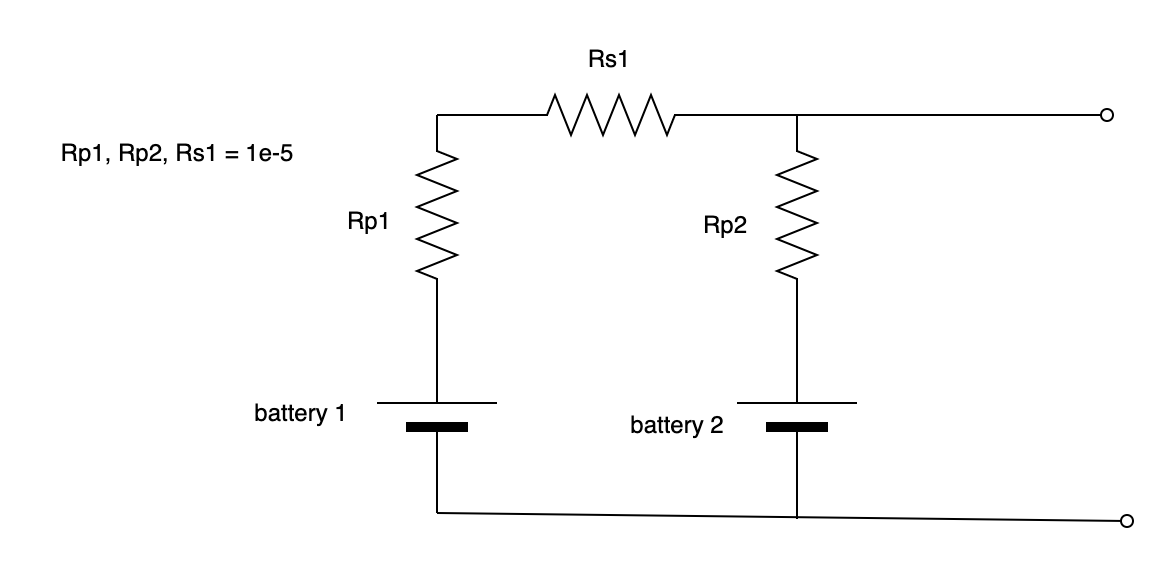

In [157]:
from IPython import display
display.Image("Two_Bat_Circuit.png")

In [158]:
Rp = 1
Rs = 1
I3 = -5
Vc = 3.4
Vd = 3.4


A = np.zeros((7, 7))

A[0, 0] = 1/Rp - 1/Rs
A[0, 1] = -1/Rp
A[0, 2] = 1/Rs

A[1, 0] = -1/Rp
A[1, 1] = 1/Rp - 1/Rs
A[1, 3] = 1/Rs
A[1, 6] = 1

A[2, 0] = -1/Rs
A[2, 2] = 1/Rs
A[2, 4] = -1

A[3, 1] = -1/Rs
A[3, 3] = 1/Rs
A[3, 5] = -1

A[4, 2] = 1

A[5, 3] = 1

A[6, 6] = 1


y = np.zeros((7, 1))
y[4, 0] = Vc
y[5, 0] = Vd
y[6, 0] = I3

np.linalg.inv(A) @ y



array([[-1.6],
       [ 3.4],
       [ 3.4],
       [ 3.4],
       [ 5. ],
       [ 0. ],
       [-5. ]])

In [188]:
def get_thickness(param):
    # Total thickness [m]
    Ln = (param['Negative current collector thickness [m]'] + param['Negative electrode thickness [m]'] + param['Separator thickness [m]'] +
        param['Positive electrode thickness [m]'] + param['Positive current collector thickness [m]'])
    return Ln


def get_avg_heat_capacity(param):

    Ln = get_thickness(param)

    # average specific heat capacity [J.kg-1.K-1]
    avg_cp = (
        (param['Negative current collector density [kg.m-3]'] * param['Negative current collector specific heat capacity [J.kg-1.K-1]'] * param['Negative current collector thickness [m]'] + \
        param['Negative electrode density [kg.m-3]'] * param['Negative electrode specific heat capacity [J.kg-1.K-1]'] * param['Negative electrode thickness [m]'] + \
        param['Separator density [kg.m-3]'] * param['Separator specific heat capacity [J.kg-1.K-1]'] * param['Separator thickness [m]'] + \
        param['Positive electrode density [kg.m-3]'] * param['Positive electrode specific heat capacity [J.kg-1.K-1]'] * param['Positive electrode thickness [m]'] + \
        param['Positive current collector density [kg.m-3]'] * param['Positive current collector specific heat capacity [J.kg-1.K-1]'] * param['Positive current collector thickness [m]']) \
        /(param['Negative current collector density [kg.m-3]'] * param['Negative current collector thickness [m]'] +
        param['Negative electrode density [kg.m-3]'] * param['Negative electrode thickness [m]'] +
        param['Separator density [kg.m-3]'] * param['Separator thickness [m]'] +
        param['Positive electrode density [kg.m-3]'] * param['Positive electrode thickness [m]'] +
        param['Positive current collector density [kg.m-3]'] * param['Positive current collector thickness [m]']))
    
    return avg_cp

def get_avg_density(param):

    # average density [kg.m-3]

    Ln = get_thickness(param)

    avg_rho = (param['Negative current collector density [kg.m-3]'] * param['Negative current collector thickness [m]'] +
        param['Negative electrode density [kg.m-3]'] * param['Negative electrode thickness [m]'] +
        param['Separator density [kg.m-3]'] * param['Separator thickness [m]'] +
        param['Positive electrode density [kg.m-3]'] * param['Positive electrode thickness [m]'] +
        param['Positive current collector density [kg.m-3]'] * param['Positive current collector thickness [m]'])/ (
            Ln
        )

    return avg_rho

def get_avg_thermal_conductivity(param):
    Ln = get_thickness(param)
    keys = ['Negative current collector', 'Positive current collector', 'Negative electrode', 'Positive electrode', 'Separator']
    return np.sum([param[f'{key} thickness [m]'] / Ln * param[f'{key} thermal conductivity [W.m-1.K-1]'] for key in keys])
    


def get_current_details(I_input, Rbat1, Rbat2, Vocv1, Vocv2, Rs=1e-5, Rp=1e-5):
    R1 = Rp + Rbat1
    R2 = Rp + Rbat2
    I1 = (I_input*R2 + Vocv2 - Vocv1) / (R1 + Rs + R2)
    # return I1, I_input-I1
    return I_input*0.5, I_input*0.5

    

In [189]:
def thermal_simulation2(parameter_values=None):
    """
    Create a Basic PyBaMM simulation set up for integration with liionpack

    Args:
        parameter_values (pybamm.ParameterValues):
            The default is None.

    Returns:
        pybamm.Simulation:
            A simulation that can be solved individually or passed into the
            liionpack solve method

    """
    options={
            "thermal": "isothermal",
            "calculate heat source for isothermal models": "true"
        }

    # Create the pybamm model
    model = pybamm.lithium_ion.SPMe(options=options)

    # Set up parameter values
    if parameter_values is None:
        param = pybamm.ParameterValues("Chen2020")
    else:
        param = parameter_values.copy()

    # Set up solver and simulation
    # solver = pybamm.CasadiSolver(mode="safe")
    # sim = pybamm.Simulation(
    #     model=model,
    #     parameter_values=param,
    #     solver=solver,
    # )
    return model

def update_parameter(param, T_cell, Current):
    param.update({"Current function [A]" : Current, 
                            "Initial temperature [K]" : T_cell,
                            "Ambient temperature [K]" : T_cell,
                            "Negative tab heat transfer coefficient [W.m-2.K-1]": 0,
                            "Positive tab heat transfer coefficient [W.m-2.K-1]": 0,
                            "Total heat transfer coefficient [W.m-2.K-1]": 0}, 
                            check_already_exists=False)
    return param


def make_new_model(model, param, disc, update_input):
  model1 = model.new_copy()
  param1 = param.copy()
  param1.update(update_input, check_already_exists=False)
  model1 = param1.process_model(model1, inplace=False)
  built_model = disc.process_model(model1, inplace=True, check_model=True)
  return built_model


In [190]:
def heat_calculation_cells(Qs, Tinis, Ln, time, thermal_para = None):
  """
  In this example we use the following parameters:

| Symbol      | Units              | Value                                          |
|:------------|:-------------------|:-----------------------------------------------|
| $k$         | W.K-1.m-1          | $10 \times 10^{-3}$                            |
| $\rho$      | kg.m-3             | $1 \times 10^{3}$                              |
| $c_p$       | J.kg-1.K-1         | $4.186 \times 10^{3}$                          |
| $h$         | W.K-1.m-2          | $10 \times 10^{-3}$                            |
| $Tair$      | K                  | 310                                            |
| $T_0$       | K                  | 300                                            |
| $Q_{s}$     | W.m-3              | 0                                              |

  """
  if thermal_para is None:
    thermal_para = {
        "Thermal conductivity [W.K-1.m-1]": 10,
        "Density [kg.m-3]": 1e3,
        "Heat capacity [J.kg-1.K-1]": 4.186e3,
        "Heat transfer coefficient [W.K-1.m-2]": 10,
        "Air temp [K]": 310,
    }

  assert len(Qs) == len(Tinis)

  num = len(Tinis)

  model = pybamm.BaseModel()

  k = pybamm.Parameter("Thermal conductivity [W.K-1.m-1]")
  rho = pybamm.Parameter("Density [kg.m-3]")
  cp = pybamm.Parameter("Heat capacity [J.kg-1.K-1]")
  h = pybamm.Parameter("Heat transfer coefficient [W.K-1.m-2]")
  Tair = pybamm.Parameter("Air temp [K]")

  T_to_solve = [pybamm.Variable(f'Temperature T{i} [K]') for i in range(num)]

  Q_interpolate = [pybamm.Interpolant(time, Qs[i], pybamm.t) for i in range(num)]

  dTdt_to_solve = np.zeros_like(T_to_solve, dtype=object)

  delta_x = Ln/num

  dTdt_to_solve[0] = k/rho/cp/delta_x*(T_to_solve[1]-T_to_solve[0])/delta_x + Q_interpolate[0]/(rho*cp)

  dTdt_to_solve[-1] = 1/rho/cp*(Tair-T_to_solve[-1])/delta_x*h-k/rho/cp/delta_x*(T_to_solve[-1]-T_to_solve[-2])/delta_x + Q_interpolate[-1]/(rho*cp)

  if num > 2:
    for i in range(1, num-1):
      dTdt_to_solve[i] = k/rho/cp/delta_x*((T_to_solve[i+1]-T_to_solve[i])/delta_x-(T_to_solve[i]-T_to_solve[i-1])/delta_x) + Q_interpolate[i]/(rho*cp)

  model.rhs = {T_to_solve[i]: dTdt_to_solve[i] for i in range(num)}

  model.initial_conditions = {T_to_solve[i]: Tinis[i] for i in range(num)}

  param = pybamm.ParameterValues(
    thermal_para
  )
  param.process_model(model)

  model.variables = {
      f'Temperature T{i} [K]': T_to_solve[i] for i in range(num)
  }

  disc = pybamm.Discretisation()  # use the default discretisation
  disc.process_model(model)

  solver = pybamm.CasadiSolver()
  solution = solver.solve(model, time)

  return solution 

In [172]:
options={
            "thermal": "isothermal",
            "calculate heat source for isothermal models": "true"
        }

# Create the pybamm model
model = pybamm.lithium_ion.SPMe(options=options)

param = pybamm.ParameterValues("Chen2020").copy()
geometry = model.default_geometry
submesh_types = model.default_submesh_types
var_pts = model.default_var_pts
spatial_methods = model.default_spatial_methods

param.process_geometry(geometry)
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
disc = pybamm.Discretisation(mesh, spatial_methods)

In [191]:
current_input = np.ones(100+1) * 5

current_details = np.zeros((current_input.shape[0], 2))

T_bat = np.zeros_like(current_details)
T_bat[0, :] = 310

Vocv = np.zeros_like(current_details)

Rbat = np.zeros_like(current_details)

negative_particle_avg_con = np.zeros_like(current_details)

solutions = np.zeros_like(T_bat, dtype=object)

previous_solution = np.zeros_like(T_bat, dtype=object)

previous_solution[0, :] = pybamm.EmptySolution()


default_thermal_param = {
        "Thermal conductivity [W.K-1.m-1]": get_avg_thermal_conductivity(param),
        "Density [kg.m-3]": get_avg_density(param),
        "Heat capacity [J.kg-1.K-1]": get_avg_heat_capacity(param),
        "Heat transfer coefficient [W.K-1.m-2]": 10,
        "Air temp [K]": 310,
    }


### Pre solve to get internal resistance
i = 0

ini_current = np.zeros((1, 2))
ini_current[0, :] = get_current_details(current_input[0], 1e-3, 1e-3, 4.2, 4.2)

for j in range(2):
    update_input = {"Current function [A]" : ini_current[0, j], 
                            "Initial temperature [K]" : T_bat[0, j],
                            "Ambient temperature [K]" : T_bat[0, j],
                            "Negative tab heat transfer coefficient [W.m-2.K-1]": 0,
                            "Positive tab heat transfer coefficient [W.m-2.K-1]": 0,
                            "Total heat transfer coefficient [W.m-2.K-1]": 0}
    model1 = make_new_model(model, param, disc, update_input)
    solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-3)
    ini_solve = solver.step(pybamm.EmptySolution(),
                            model1,
                            1e-6,
                            npts=2,
                            save=False,)

    Rbat[0, j] = (ini_solve["Surface open-circuit voltage [V]"](t=1e-6) - ini_solve["Terminal voltage [V]"](t=1e-6))/ini_current[0, j]
    Vocv[0, j] = ini_solve["Surface open-circuit voltage [V]"](t=1e-6)
    negative_particle_avg_con[0, j] = ini_solve["Average negative particle concentration [mol.m-3]"](t=1e-6)

current_details[0, :] = get_current_details(current_input[0], Rbat[0, 0], Rbat[0, 1], Vocv[0, 0], Vocv[0, 1])

for i in range(current_input.shape[0]-1):

    for j in range(2):
        
        update_input = {"Current function [A]" : current_details[i, j], 
                                "Initial temperature [K]" : T_bat[i, j],
                                "Ambient temperature [K]" : T_bat[i, j],
                                "Negative tab heat transfer coefficient [W.m-2.K-1]": 0,
                                "Positive tab heat transfer coefficient [W.m-2.K-1]": 0,
                                "Total heat transfer coefficient [W.m-2.K-1]": 0}
        
        model1 = make_new_model(model, param, disc, update_input)
        solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-3)
        step_solution = solver.step(previous_solution[i, j],
                                        model1,
                                        10,
                                        npts=11,
                                        save=False,)
                                        
        previous_solution[i+1, j] = step_solution.last_state

        solutions[i, j] = step_solution

    q1 = solutions[i, 0]["X-averaged total heating [W.m-3]"](t=step_solution.t)
    q2 = solutions[i, 1]["X-averaged total heating [W.m-3]"](t=step_solution.t)

    Vocv1 = solutions[i, 0]["Surface open-circuit voltage [V]"](t=step_solution.t[-1])
    Vocv2 = solutions[i, 1]["Surface open-circuit voltage [V]"](t=step_solution.t[-1])

    Vter1 = solutions[i, 0]["Terminal voltage [V]"](t=step_solution.t[-1])
    Vter2 = solutions[i, 1]["Terminal voltage [V]"](t=step_solution.t[-1])

    R1 = np.abs((Vter1 - Vocv1)/current_details[i, 0])
    R2 = np.abs((Vter2 - Vocv2)/current_details[i, 1])

    Vocv[i+1, 0] = Vocv1
    Vocv[i+1, 1] = Vocv2

    Rbat[i+1, 0] = R1
    Rbat[i+1, 1] = R2

    negative_particle_avg_con[i+1, 0] = solutions[i, 0]["Average negative particle concentration [mol.m-3]"](t=step_solution.t[-1])
    negative_particle_avg_con[i+1, 1] = solutions[i, 1]["Average negative particle concentration [mol.m-3]"](t=step_solution.t[-1])

    if i+1 < current_details.shape[0]:
        if q1[0] == np.NaN:
            q1[0] = solutions[i-1, 0]["X-averaged total heating [W.m-3]"](t=step_solution.t[0])
            q2[0] = solutions[i-1, 1]["X-averaged total heating [W.m-3]"](t=step_solution.t[0])

        #thermal_sol = heat_calculation_cells([q1*0, q2*0], [T_bat[i, 0], T_bat[i, 1]], get_thickness(param), step_solution.t, thermal_para = default_thermal_param)

        T_bat[i+1, 0] = T_bat[i, 0]#thermal_sol['Temperature T0 [K]'](t=step_solution.t)[-1]
        T_bat[i+1, 1] = T_bat[i, 1]#thermal_sol['Temperature T1 [K]'](t=step_solution.t)[-1]

        current_details[i+1, :] = get_current_details(current_input[i+1], Rbat[i+1, 0], Rbat[i+1, 1], Vocv[i+1, 0], Vocv[i+1, 1])

In [192]:
time = np.linspace(0, current_details.shape[0]-1, current_details.shape[0]) * 10

electrode_area = param["Electrode height [m]"] * param["Electrode width [m]"]

fig = make_subplots(

)

fig.add_trace(
    go.Scatter(
        x=time, y=current_details[:, 0], name="cell_1"
    )
)

fig.add_trace(
    go.Scatter(
        x=time, y=current_details[:, 1], name="cell_2"
    )
)

fig.update_layout(
    title="Current Density (A/m2)",
    xaxis_title="Time (s)",
    yaxis_title="Current Density (A/m2)",
    legend_title="Cell",
)



In [193]:
fig = make_subplots(

)

fig.add_trace(
    go.Scatter(
        x=time, y=T_bat[:, 0], name="cell_1"
    )
)

fig.add_trace(
    go.Scatter(
        x=time, y=T_bat[:, 1], name="cell_2"
    )
)

fig.update_layout(
    title="Cell Temp",
    xaxis_title="Time (s)",
    yaxis_title="Temperature (K)",
    legend_title="Cell Id",
)

In [183]:
fig = make_subplots(

)

fig.add_trace(
    go.Scatter(
        x=time, y=Vocv[:, 0], name="cell_1"
    )
)

fig.add_trace(
    go.Scatter(
        x=time, y=Vocv[:, 1], name="cell_2"
    )
)

fig.update_layout(
    title="Cell Voltage",
    xaxis_title="Time (s)",
    yaxis_title="Voltage (V)",
    legend_title="Cell Id",
)

In [194]:
fig = make_subplots(

)

fig.add_trace(
    go.Scatter(
        x=time, y=negative_particle_avg_con[:, 0], name="cell_1"
    )
)

fig.add_trace(
    go.Scatter(
        x=time, y=negative_particle_avg_con[:, 1], name="cell_2"
    )
)

fig.update_layout(
    title="Avg Particle Concentration",
    xaxis_title="Time (s)",
    yaxis_title="Li-ion Concentration (mol/m3)",
    legend_title="Cell Id",
)

In [195]:
fig = make_subplots(

)

fig.add_trace(
    go.Scatter(
        x=time, y=Rbat[:, 0], name="cell_1"
    )
)

fig.add_trace(
    go.Scatter(
        x=time, y=Rbat[:, 1], name="cell_2"
    )
)

fig.update_layout(
    title="Internal Resistance",
    xaxis_title="Time (s)",
    yaxis_title="Resistance (ohm)",
    legend_title="Cell Id",
)